In [2]:
ROOT_DIR = "/home/user/Documents/projects/Metaworld"
%env MUJOCO_GL=egl

import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib

# scientific
import cv2
import numpy as np
import torch
import pytorch_lightning as pl

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import keyframes.pl_modules as pl_modules
import utils.predict_utils as keyframe_predict

import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils
import utils.transform_utils as transform_utils
import utils.inference_utils as inference_utils
import keyframes.seg_any as seg_any

DEVICE = "cuda"

env: MUJOCO_GL=egl


In [3]:
env_idx_excluded = [1,22,31,41,42]
name2idx = {}
for i, name in enumerate(env_utils.env_names):
    name2idx[name] = i
[env_utils.env_names[i] for i in env_idx_excluded]

config = inference_utils.load_config("feature_matching", "01")
ckpt_path = "/home/user/Documents/projects/osil/metaworld/vkzro9co/checkpoints/epoch=34-step=3885.ckpt"
model = pl_modules.PLModel(config["model_args"], config["optimizer_args"])
model = model.load_from_checkpoint(ckpt_path)
model.to("cpu")
model.eval();

In [22]:
importlib.reload(seg_any)

<module 'keyframes.seg_any' from '/home/user/Documents/projects/Metaworld/keyframes/seg_any.py'>

(360, 480, 3) (24, 2)


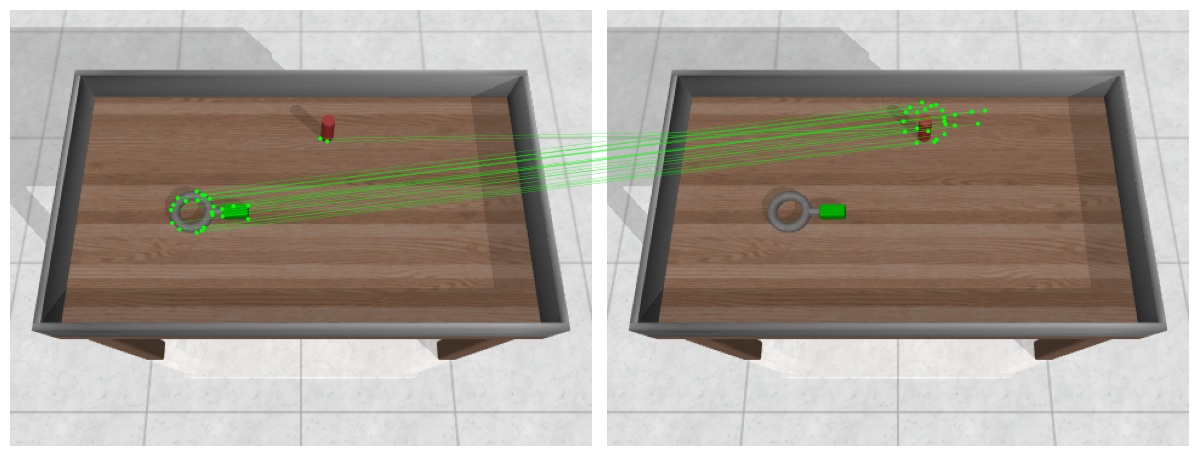

In [28]:
# 1) Infer on task

# generate keyframes
env_index = 0
img_height, img_width = 360, 480
env, expert_policy, renderer = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width)
T_world2pixel = cu.get_camera_transform_matrix(env, "keyframes", img_height, img_width)
T_pixel2world = np.linalg.inv(T_world2pixel)
extractor = slam_utils.get_super_glue_extractor()
# TODO
keyframe_data_0 = keyframe_utils.generate_keyframe_data_with_features(env, renderer, extractor)
keyframe_data_1 = keyframe_utils.generate_keyframe_data_with_features(env, renderer, extractor)
res = inference_utils.predict_feature_movement(model, extractor, env.model.ngeom, keyframe_data_0, keyframe_data_1, T_world2pixel, T_pixel2world)
print(keyframe_data_1["img"][0].shape, res["kpts"]["kpts_2_0"].numpy().shape)

In [23]:
# create seg any predictor
seg_any_predictor = seg_any.SegAny(
    "/home/user/Documents/projects/osil/sam_vit_h_4b8939.pth", 
    (360, 480)
)

In [24]:
# call seg any predictor
img = keyframe_data_1["img"][0]
points = res["kpts"]["kpts_2_0"].numpy()

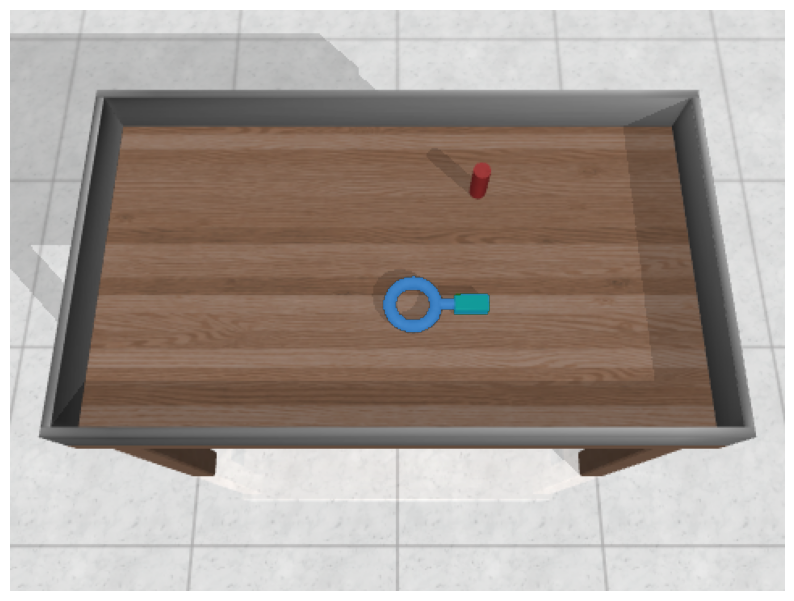

In [29]:
mask = seg_any_predictor.compute_mask(
    img=img, 
    points=points
)
plt.figure(figsize=(10,10))
plt.imshow(img)
seg_any.show_mask(mask, plt.gca())
#show_points(input_points, input_labels, plt.gca())
# plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show() 

In [25]:
# save mask

# TODO why save other data here
wpos_kpts_1_0 = depth_utils.pixel_coords_to_world_coords_simple(
    T_pixel2world, 
    keyframe_data_1["depth"][0],
)[:,:3]

# Assuming you have a NumPy array called 'array' that you want to save
out_folder = "/home/user/Documents/projects/Metaworld/keyframes/test_data"
np.save(f'{out_folder}/seg_assembly.npy', mask]
np.save(f'{out_folder}/img_assembly.npy', img)
np.save(f'{out_folder}/xyz_assembly.npy', wpos_kpts_1_0)